In [41]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs # 使用 make_blobs 生成数据
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [42]:
# 1. 生成模拟数据 (使用 make_blobs)
X, y = make_blobs(n_samples=300, centers=4, cluster_std=2.0, random_state=42)

In [43]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("生成数据总数:", len(X))
print("训练集形状:", X_train.shape, y_train.shape)
print("测试集形状:", X_test.shape, y_test.shape)

生成数据总数: 300
训练集形状: (210, 2) (210,)
测试集形状: (90, 2) (90,)


In [44]:
# 2. 实现 KNN 分类器功能 (使用函数)

def euclidean_distance(x1, x2):
    """
    计算两个样本点之间的欧几里得距离。

    Args:
        x1 (np.ndarray): 第一个样本点。
        x2 (np.ndarray): 第二个样本点。

    Returns:
        float: 欧几里得距离。
    """
    if x1.shape != x2.shape:
        raise ValueError("Points must have the same dimensions for distance calculation.")
    return np.linalg.norm(x1 - x2) # 使用 np.linalg.norm 更简洁高效

In [45]:
def find_k_nearest(x_test_point, X_train, k):
    """
    找到单个测试样本在训练集中的 K 个最近邻居的索引。

    Args:
        x_test_point (np.ndarray): 单个测试样本点。
        X_train (np.ndarray): 训练数据特征矩阵。
        k (int): 近邻的数量。

    Returns:
        np.ndarray: K 个最近邻居在 X_train 中的索引。
    """
    if k > X_train.shape[0]:
        print(f"Warning: k ({k}) is greater than the number of training samples ({X_train.shape[0]}). Setting k to the number of training samples.")
        k = X_train.shape[0]

    # 计算当前测试样本与所有训练样本的距离 (向量化计算)
    distances = np.linalg.norm(X_train - x_test_point, axis=1)

    # 获取 K 个最近邻居的索引
    k_indices = np.argsort(distances)[:k]

    return k_indices


In [46]:
def predict_single(x_test_point, X_train, y_train, k):
    """
    预测单个测试样本的类别。

    Args:
        x_test_point (np.ndarray): 单个测试样本点。
        X_train (np.ndarray): 训练数据特征矩阵。
        y_train (np.ndarray): 训练数据标签向量。
        k (int): 近邻的数量。

    Returns:
        int: 预测的类别标签。
    """
    # 找到 K 个最近邻居的索引
    k_indices = find_k_nearest(x_test_point, X_train, k)

    # 获取这 K 个邻居的标签
    k_nearest_labels = y_train[k_indices]

    # 执行多数投票，确定预测类别
    most_common = Counter(k_nearest_labels).most_common(1)
    predicted_label = most_common[0][0]

    return predicted_label

In [47]:
def predict_knn(X_test, X_train, y_train, k):
    """
    预测多个测试样本的类别。

    Args:
        X_test (np.ndarray): 测试数据特征矩阵。
        X_train (np.ndarray): 训练数据特征矩阵。
        y_train (np.ndarray): 训练数据标签向量。
        k (int): 近邻的数量。

    Returns:
        np.ndarray: 预测的类别标签向量。
    """
    if not isinstance(k, int) or k <= 0:
        raise ValueError("k must be a positive integer")
    if X_train.shape[0] != y_train.shape[0]:
         raise ValueError("Number of samples in X_train and y_train must match.")
    if k > X_train.shape[0]:
         print(f"Warning: k ({k}) is greater than the number of training samples ({X_train.shape[0]}). Prediction will use up to {X_train.shape[0]} neighbors.")


    # 对测试集中的每个样本点调用 predict_single 方法进行预测
    predictions = np.array([predict_single(x, X_train, y_train, k) for x in X_test])
    return predictions

In [48]:
# 3. 进行分类并可视化决策边界和预测值

# 设置 K 值
k_value = 5 # 保持 K 值与之前可视化决策边界一致

In [49]:
# 在测试集上进行预测
y_pred = predict_knn(X_test, X_train, y_train, k_value)

In [50]:
# 计算准确率 (可选)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"\n测试集准确率 (K={k_value}): {accuracy:.4f}")


测试集准确率 (K=5): 0.9778


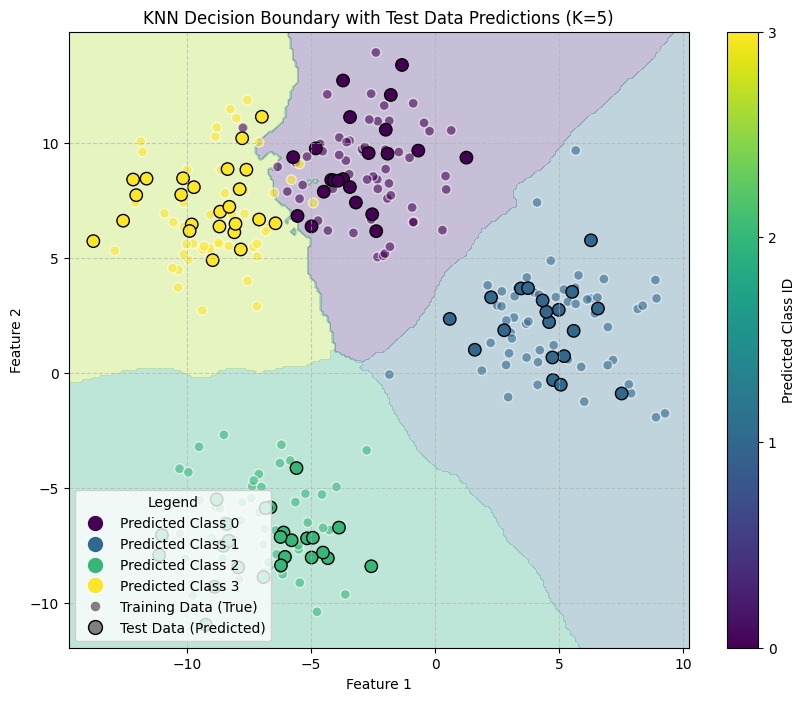

In [51]:
# 可视化决策边界和测试数据（按预测标签上色）
plt.figure(figsize=(10, 8))
# 定义网格范围，覆盖所有数据点
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# 生成网格点
h = .1 # 网格步长
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# 对网格中的每个点进行预测
grid_points = np.c_[xx.ravel(), yy.ravel()]
# 直接调用 predict_knn 函数进行预测
Z = predict_knn(grid_points, X_train, y_train, k_value)

# 将预测结果 reshape 回网格形状
Z = Z.reshape(xx.shape)

# 获取唯一的类别标签和对应的颜色映射
unique_classes = sorted(np.unique(y))
cmap_viridis = plt.colormaps['viridis']
colors = cmap_viridis(np.linspace(0, 1, len(unique_classes)))


# 绘制决策边界的填充区域
plt.contourf(xx, yy, Z, levels=np.arange(-0.5, len(unique_classes)), cmap=cmap_viridis, alpha=0.3)


# （可选）绘制训练数据点，作为背景参考
scatter_train = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_viridis,
                            edgecolor='white', s=50, label='Training Data (True)', alpha=0.6)


# 绘制测试数据点，根据预测标签上色，使用不同标记
scatter_test_pred = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=cmap_viridis,
                           marker='o', edgecolor='k', s=80, label=f'Test Data (Predicted, K={k_value})', alpha=1.0)


plt.title(f'KNN Decision Boundary with Test Data Predictions (K={k_value})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
# --- 手动创建图例元素 ---
legend_handles = []
# 为每个类别创建图例项（代表决策区域/预测类别）
for i, class_id in enumerate(unique_classes):
    handle = mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None',
                           markersize=10, label=f'Predicted Class {class_id}')
    legend_handles.append(handle)

# 添加训练数据和测试数据的图例项
handle_train = mlines.Line2D([], [], color='gray', marker='o', linestyle='None',
                            markeredgecolor='white', markersize=8, label='Training Data (True)')
legend_handles.append(handle_train)

handle_test_pred = mlines.Line2D([], [], color='gray', marker='o', linestyle='None',
                               markeredgecolor='k', markersize=10, label=f'Test Data (Predicted)')
legend_handles.append(handle_test_pred)


# 将图例添加到图上
plt.legend(handles=legend_handles, loc="lower left", title="Legend")


# 添加颜色条（可选）
cbar = plt.colorbar(scatter_test_pred, ticks=unique_classes, label='Predicted Class ID')
cbar.set_ticklabels(unique_classes)


plt.grid(True, linestyle='--', alpha=0.6)
plt.show()